<a href="https://colab.research.google.com/github/mingjiez912/Machine_Learning_Lab/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.) Import an asset price from Yahoo Finance

In [31]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

stock_data = yf.download("MSFT", start="1990-01-01", end="2022-02-21")

# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)

# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


In [32]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.605903,0.616319,0.598090,0.616319,0.384521,53035200
1990-01-03,0.621528,0.626736,0.614583,0.619792,0.386687,113774400
1990-01-04,0.619792,0.638889,0.616319,0.638021,0.398060,125740800
1990-01-05,0.635417,0.638889,0.621528,0.622396,0.388312,69566400
1990-01-08,0.621528,0.631944,0.614583,0.631944,0.394269,58982400
...,...,...,...,...,...,...
2022-02-14,293.769989,296.760010,291.350006,295.000000,291.531281,36359500
2022-02-15,300.010010,300.799988,297.019989,300.470001,296.936981,27058300
2022-02-16,298.369995,300.869995,293.679993,299.500000,296.590363,29982100


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [34]:
x_train = []
y_train = []

input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
6472/6472 [==============================] - 65s 9ms/step - loss: 0.0107 - accuracy: 0.0181
Epoch 2/3
6472/6472 [==============================] - 59s 9ms/step - loss: 0.0074 - accuracy: 0.0181
Epoch 3/3
6472/6472 [==============================] - 60s 9ms/step - loss: 0.0074 - accuracy: 0.0181


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [35]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

test_predictions = model.predict(x_test)

# Convert predictions to binary values (up or down)
binary_test_predictions = []
for i in range(len(test_predictions)):
    if test_predictions[i] >= 0.5:
        binary_test_predictions.append(1)
    else:
        binary_test_predictions.append(0)

# Evaluate out of sample accuracy
correct_test_predictions = 0
for i in range(len(binary_test_predictions)):
    if binary_test_predictions[i] == y_test[i]:
        correct_test_predictions += 1
outofsample_accuracy = correct_test_predictions / len(binary_test_predictions)
print(f'Out of sample accuracy = {outofsample_accuracy}')

51/51 [==============================] - 2s 5ms/step
Out of sample accuracy = 0.008641975308641974


In [36]:
train_predictions = model.predict(x_train)

binary_train_predictions = []
for i in range(len(train_predictions)):
    if train_predictions[i] >= 0.5:
        binary_train_predictions.append(1)
    else:
        binary_train_predictions.append(0)

# Evaluate insample accuracy
correct_train_predictions = 0
for i in range(len(binary_train_predictions)):
    if binary_train_predictions[i] == y_train[i]:
        correct_train_predictions += 1
insample_accuracy = correct_train_predictions / len(binary_train_predictions)
print(f'Insample accuracy = {insample_accuracy}')

203/203 [==============================] - 1s 5ms/step
Insample accuracy = 0.0180778739184178


In [37]:
import random

# Generate a list of random integers between 0 and 1
rw_train_num = [random.randint(0, 1) for i in range(len(binary_train_predictions))]

# Assign the list to a new variable
rw_train = rw_train_num

# Evaluate random walk insample accuracy
correct_rw_train_predictions = 0
for i in range(len(rw_train_num)):
    if rw_train_num[i] == y_train[i]:
        correct_rw_train_predictions += 1
insample_rw_accuracy = correct_rw_train_predictions / len(rw_train_num)
print(f'Random Walk Insample accuracy = {insample_rw_accuracy}')

Random Walk Insample accuracy = 0.00865265760197775


In [40]:
rw_test_num = [random.randint(0, 1) for i in range(len(binary_test_predictions))]

# Assign the list to a new variable
rw_test = rw_test_num

# Evaluate random walk out of sample accuracy
correct_rw_test_predictions = 0
for i in range(len(rw_test_num)):
    if rw_test_num[i] == y_test[i]:
        correct_rw_test_predictions += 1
outofsample_rw_accuracy = correct_rw_test_predictions / len(rw_test_num)
print(f'Random Walk Out of Sample accuracy = {outofsample_rw_accuracy}')

Random Walk Out of Sample accuracy = 0.0049382716049382715


<BarContainer object of 4 artists>

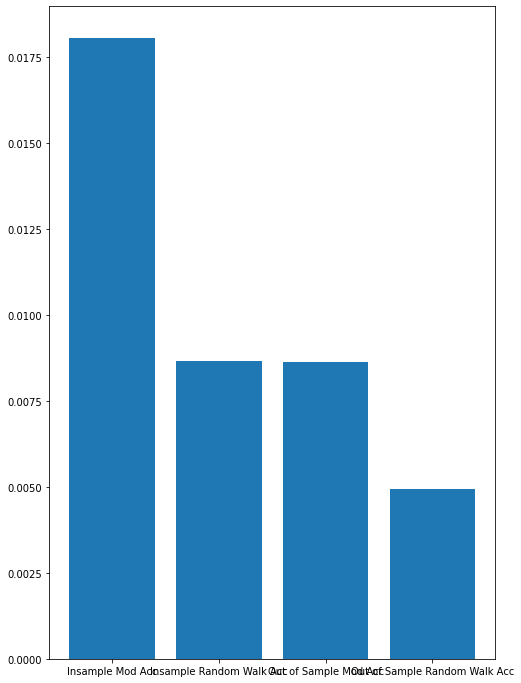

In [39]:
import matplotlib.pyplot as plt 

plt.figure(figsize = (8, 12))
plt.bar(['Insample Mod Acc', 'Insample Random Walk Acc', 'Out of Sample Mod Acc', 'Out of Sample Random Walk Acc'], 
        [insample_accuracy, insample_rw_accuracy, outofsample_accuracy, outofsample_rw_accuracy])

# 4.) Plot in and out of sample accuracy

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)

plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

The LSTM model performs better than the Random Walk. 

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [29]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
def create_model():
    model = Sequential()
    model.add(LSTM(50))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
param_grid = {'batch_size': [10, 20, 50],
              'epochs': [1, 10]}

# Perform the grid search over the hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-29-32e24ccd2999>:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best: -0.007158 using {'batch_size': 50, 'epochs': 1}
